# Exercise 4

## Preliminaries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    

batch_size = 128

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
#Converts label idx (n labels total) into one-hot encoding
def idx2onehot(idx, n):

    idx = idx.to(device)

    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)

    onehot = torch.zeros(idx.size(0), n).to(device)
    onehot.scatter_(1, idx, 1)

    return onehot

#example:
idx2onehot(3*torch.ones(7, dtype=torch.long),n=10)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

## Basics/Repetition  of VAE

In the lecture we have shown that $$\log p^*(x^{(i)}) \ge  -  D_{KL}[p_E(z \mid x^{(i)}) \| p(z)] +\mathbb{E}_{z\sim p_E(z \mid x^{(i)})} [\log p_D (x^{(i)} \mid z)] = -\mathcal{L}(D, E, x^{(i)}),$$
where $x^{(i)}\in\mathbb{R}^D$ is the $i$-th training instance (since the pixel values of MNIST images are in the range 0...1, we even have $x^{(i)}\in[0,1]^D$ in this case). The LHS is the logarithm of the true data distribution, and the RHS is termed the "evicence lower bound" (ELBO).

We call $p_E(z \mid x)$ the encoder and $p_D( x \mid z)$ the decoder. Both will be represented by neural networks. Our goal is to approximate $p^*(x)$ as well as possible by maximizing the ELBO or equivalently minimizing its negation. Specifically, we minimize $\mathcal{L}(D, E, x^{(i)})$ with respect to the parameters of the decoder network $D$ and the encoder network $E$ via gradient descent over all training instances $i$. 

In order to estimate the negative ELBO, we approximate the expectation w.r.t. $z$ by its average over $L$ instances:
\begin{align} \hat{\mathcal{L}}(D, E, x^{(i)}) = D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right]+ \frac{1}{L} \sum_{l=1}^L \left(-\log p_D(x^{(i)} \mid z^{(i,l)})\right)\end{align} 
where $z^{(i,l)} \sim p_E(z \mid x^{(i)}) $. By construction of a VAE, $p_E(z \mid x^{(i)})$ is a Gaussian distribution whose mean $\mu^{(i)}=\mu_E(x^{(i)})$ and standard deviation $\sigma^{(i)}=\sigma_E(x^{(i)})$ are computed by the encoder network. For fixed $x^{(i)}$, we can draw samples $z^{(i,l)}$ from this code distribution by means of the reparametrization trick: 
$$z^{(i,l)}\sim \mathcal{N}\big(\mu^{(i)}, \text{diag}(\sigma^{(i)})^2\big) \Leftrightarrow  z^{(i,l)} = \mu^{(i)} + \epsilon_l \cdot \sigma^{(i)}$$ 
with $\epsilon_l\sim\mathcal{N}(0, \mathbb{I})$. Note that $\mu^{(i)}$, $\sigma^{(i)}$, and $\epsilon_l$ are vectors of length equal to the dimension $J$ of the latent space, and $\epsilon_l \cdot \sigma^{(i)}$ is element-wise multiplication. In practice, $L=1$ is usually sufficient so that the average over index $l$ becomes trivial.

Furthermore, we assume that the latent prior is a standard normal distribution, i.e. $p(z) = \mathcal{N}(0, \mathbb{I})$. The KL-term for the two multivariate normal distributions can then be computed analytically:
$$ D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right] = \frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) $$

Likewise, we consider $p_D(x \mid z)$ as a Gaussian distribution with mean $\mu_D(z)$ and fixed covariance matrix $\sigma_G^2\cdot \mathbb{I}$ (i.e. $\sigma_G$ is the fixed noise standard deviation):
$$ p_G(x \mid z) = \mathcal{N}\big(\mu_D(z), \sigma_G^2\cdot\mathbb{I}\big)$$
To ensure that $\mu_D(z) \in [0,1]^D$ holds for reconstructed images (without noise), the decoder's output layer should use the sigmoid activation function. The second term in the negated ELBO (the negative log-likelihood) now reduces to the squared loss:
$$-\log p_D(x^{(i)} \mid z^{(i,l)}) = \frac{||x^{(i)} - \mu_D(z^{(i,l)})||^2_2}{2 \sigma_G^2}  + \text{const.}$$
The additive constant has no influence on the training optimimum and can be dropped. $\sigma_G$ can be used as a hyperparameter to balance the two loss terms.

For a batch of samples $X = (x^{(1)}, \dots, x^{(M)})$, we finally get the negated ELBO as:
\begin{align} -ELBO = \sum_{i=1}^M \Big[&\frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) \\+& \frac{1}{L} \sum_{l=1}^L \sum_{j=1}^D \frac{(x^{(i)}_j - \mu_D(z^{(i,l)})_j)^2}{2\sigma_G^2}\Big]\end{align}
Training is performed by gradient descent on this loss.

## Task 1: Implementation of VAE and CVAE

Complete the code below. The CVAE class consists of three parts
* The Encoder class that implements $p_E (z \mid x, y)$,
* The Decoder class which implements $p_D (x \mid z, y)$ and
* The actual CVAE class that combines both encoder and decoder.

The conditioning variable $y$ holds the labels, e.g. 0...9 for MNIST digits. It is added as an additional network input, i.e. the encoder computes $\mu_E(x^{(i)}, y^{(i)})$ and $\sigma_E(x^{(i)}, y^{(i)})$. The decoder produces the reconstruction `recon_x`=$\mu_D(z^{(i)}, y^{(i)})$, where $z^{(i)}$ is sampled using the reparametrization trick explained above. 

Implement all three classes. The arguments and outputs for each method are given in the docstrings. Make sure the CVAE class implements both the conditional VAE (CVAE) and the plain VAE, where the latter is obtained if the number of labels is just 1. 

In [3]:
class CVAE(nn.Module):

    def __init__(self, inp_dim, encoder_layer_sizes, decoder_layer_sizes, latent_dim, num_labels=10, conditional=False):
        """
        Arguments:
            inp_dim (int): dimension of input,
            encoder_layer_sizes (list[int]): list of the sizes of the encoder layers,
            decoder_layer_sizes (list[int]): list of the sizes of the decoder layers,
            latent_dim (int): dimension of latent space/bottleneck,
            num_labels (int): amount of labels (important for conditional VAE),,
            conditional (bool): True if CVAE, else False

        """
        
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        self.conditional = conditional
        
        self.encoder = Encoder(encoder_layer_sizes, latent_dim, num_labels, conditional)
        self.decoder = Decoder(decoder_layer_sizes, latent_dim, num_labels, conditional)
        
    def forward(self, x, c=None):
        """
        Forward Process of whole VAE/CVAE. 
        Arguments:
            x: tensor of dimension (batch_size, 1, 28, 28) or (batch_size, 28*28)
            c: None or tensor of dimension (batch_size, 1)
        Output: recon_x, means, log_var
            recon_x: see explanation on second part of estimator above,
            means: output of encoder,
            log_var: output of encoder (logarithm of variance)
        """
        batch_size = x.size(0)

        x = x.view(-1,784)

        if self.conditional:
            c = idx2onehot(c, self.num_labels).to(device)
            x = torch.cat([x, c], axis=-1).to(device)

        means, log_var = self.encoder(x)

        #z = torch.normal(means, log_var).to(device)
        epsilon = torch.normal(0, 1, (batch_size, self.latent_dim)).to(device)
        z = means + epsilon * torch.square(torch.exp(log_var)).to(device)

        if self.conditional:
            z = torch.cat([z, c], axis=-1).to(device)

        recon_x = self.decoder(z)

        return recon_x, means, log_var
        
    def sampling(self, n=2, c=None):
        """
        Generates new samples by feeding a random latent vector to the decoder.
        Arguments:
            n (int): amount of samples 
            c      : None or tensor of dimension (batch_size, 1) (labels to condition on)
        Output:
            x_sampled: n randomly sampled elements of the output distribution
        """
        z = torch.normal(0, 1, (n, self.latent_dim)).to(device)

        if self.conditional:
            c = idx2onehot(c, self.num_labels).to(device)
            z = torch.cat([z, c], axis=-1).to(device)
        
        x_sampled = self.decoder(z)

        return x_sampled 
    
class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim, num_labels, conditional=False):
        super(Encoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of layers of the encoder,
            latent_dim (int): dimension of latent space, i.e. dimension out output of the encoder,
            num_labels (int): amount of labels,
            conditional (bool): True if CVAE and False if VAE
        """
        if conditional:
            self.num_cond = num_labels
        else:
            self.num_cond = 0

        self.layer_sizes = layer_sizes
        self.latent_dim = latent_dim
        self.num_lables = num_labels

        self.lin1 = nn.Linear(self.layer_sizes[0]+self.num_cond, self.layer_sizes[1])
        self.lin2 = nn.Linear(self.layer_sizes[1], self.layer_sizes[2])
        self.means = nn.Linear(self.layer_sizes[2], self.latent_dim)
        self.log_vars = nn.Linear(self.layer_sizes[2], self.latent_dim)

    
    def forward(self, x, c=None):  
        """
        Arguments:
            x: tensor of dimension (batch_size, 1, 28, 28) or (batch_size, 28*28)
            c: None or tensor of dimension (batch_size, 1)
        Output:
            means: tensor of dimension (batch_size, latent_dim),
            log_var: tensor of dimension (batch_size, latent_dim)
        """
        x2 = F.relu(self.lin1(x)).to(device)
        x3 = F.relu(self.lin2(x2)).to(device)
        means = self.means(x3).to(device)
        log_vars = self.log_vars(x3).to(device)
     
        return means, log_vars
    
    
class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim, num_labels, conditional=False):     
        super(Decoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of layers of the decoder,
            latent_dim (int): dimension of latent space, i.e. dimension out input of the decoder,
            num_labels (int): amount of labels,
            conditional (bool): True if CVAE and False if VAE
        Output:
            x: Parameters of gaussian distribution; only mu (see above)
        """
        if conditional:
            self.num_cond = num_labels
        else:
            self.num_cond = 0

        self.layer_sizes = layer_sizes
        self.latent_dim = latent_dim
        self.num_lables = num_labels

        self.lin1 = nn.Linear(self.latent_dim+self.num_cond, self.layer_sizes[0])
        self.lin2 = nn.Linear(self.layer_sizes[0], self.layer_sizes[1])
        self.lin3 = nn.Linear(self.layer_sizes[1], self.layer_sizes[2])
            
    def forward(self, z, c=None):
        """
        Argumetns:
            z: tensor of dimension (batch_size, latent_dim)
            c: None or tensor of dimension (batch_size, 1)
        Outputs:
            x: mu of gaussian distribution (reconstructed image from latent code z)
        """

        x = F.relu(self.lin1(z)).to(device)
        x2 = F.relu(self.lin2(x)).to(device)
        x3 = torch.sigmoid(self.lin3(x2)).to(device)
    

        return x3

### Loss Function

We want to minimize the negated ELBO loss:
$$\hat{\mathcal{L}}(D, E, x^{(i)}) = D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right]+ \frac{1}{L} \sum_{l=1}^L \left(-\log p_D(x^{(i)} \mid z^{(i,l)})\right)$$
where $L=1$. The `loss_function` should implement this estimator, expanding the two terms as explained above.
* Implement the loss function
* Comment/explain how your code arises from the formula above.

Hint: Use the following choice of hyperparameter $\sigma_G = 1$.

In [4]:
def loss_function(recon_x, x, mu, log_var):
    """
    Arguments:
        recon_x: reconstruced input
        x: input,
        mu, log_var: parameters of posterior (distribution of z given x)
    """
    x = x.view(-1, 784)
    log_p_d = torch.norm(x-recon_x, dim=-1, p=2)**2/2
    D_kl = torch.sum(mu**2+torch.exp(log_var)**2-2*log_var-1, axis=-1)/2
    
    return torch.sum(D_kl + log_p_d)

### Training of VAE
Before we can do funny things with our VAE, we train it with a bottleneck size of two. If everything has been implemented correctly, you should obtain an VAE after a few epochs that is able to generate recognizable MNIST samples. 

The amount of layers as well as their dimensions do not have to be changed throughout this exercise. Better results might by achieved by searching for different hyperparameters.
* Simply run the code to train the VAE

In [25]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]

latent_dim = 2 
vae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training of the VAE
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        
        recon_batch,  mu, log_var = vae(x)
        loss = loss_function(recon_batch,  x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
epochs = 15
for epoch in range(epochs):
    train(epoch)  
#torch.save(vae.state_dict(), 'vae.pt')

vae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae.load_state_dict(torch.load('vae.pt'))
vae.to(device)
vae.eval()

Train Epoch: 0 [0/60000 (0%)]	Loss: 5839.860352
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1604.968018
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1649.636963
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1412.835938
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1670.952271
====> Epoch: 0 Average loss: 25.8417
Train Epoch: 1 [0/60000 (0%)]	Loss: 1443.666504
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1428.003662
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1400.003174
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1302.471680
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1424.834229
====> Epoch: 1 Average loss: 22.1794
Train Epoch: 2 [0/60000 (0%)]	Loss: 1289.714355
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1295.581421
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1298.526978
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1259.725586
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1331.028564
====> Epoch: 2 Average loss: 20.4802
Train Epoch: 3 [0/60000 (0%)]	Loss: 1185.807861
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1267.681519
Train Ep

CVAE(
  (encoder): Encoder(
    (lin1): Linear(in_features=784, out_features=512, bias=True)
    (lin2): Linear(in_features=512, out_features=256, bias=True)
    (means): Linear(in_features=256, out_features=2, bias=True)
    (log_vars): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=2, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=512, bias=True)
    (lin3): Linear(in_features=512, out_features=784, bias=True)
  )
)

### Sanity Check VAE
Your model should be able to reproduce the input image, i.e. the output of the VAE should look similar to be input. 
 
* Run the code to check if your model worked
* How are the reconstructions different from the original?

Original             Reconstructed


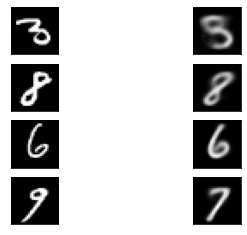

In [7]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(npimg, vmin=0, vmax=1, cmap='gray')
    plt.xticks([])
    plt.yticks([])

_, x= next(enumerate(train_loader))
samples = x[0].to(device)[30:]
samples_rec,   _, _ = vae(samples)
samples_rec = samples_rec.detach().cpu().view(-1,28,28)
print("Original             Reconstructed")
for i in range(0, 4):
  plt.subplot(4,2,2*i+1)
  imshow(samples[i,0])
    
  plt.subplot(4, 2, 2*i+2)
  imshow(samples_rec[i])
plt.show()

The reconstructions are way less sharp and don't necessarily look like the number they are supposed to represent, but sometimes more like a mixture between multiple numbers.

Your model should be able to generate images that look similar to the samples of the MNIST dataset.
* Run the code
* Describe what you see

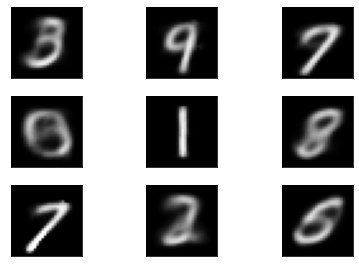

In [8]:
for i in range(1, 10):
    plt.subplot(3,3,i)
    sample = vae.sampling(n=1).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])
plt.show()

We see the same difference to the original MNIST data as described above.

### Training a second VAE with larger latent space dimension
Note that the quality of the reconstruction will also depend on the dimension of the latent space. To explore this, train a second model called `vae2` and use it to reconstruct a few example digits to evaluate the change in quality. Comment on your findings.

In [26]:
latent_dim = 16
vae2 = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae2 = vae2.to(device)
optimizer = optim.Adam(vae2.parameters(), lr=1e-3)

# Training of the VAE
def train2(epoch):
    vae2.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        
        recon_batch,  mu, log_var = vae2(x)
        loss = loss_function(recon_batch,  x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
epochs = 15
for epoch in range(epochs):
    train2(epoch)  
#torch.save(vae2.state_dict(), 'vae2.pt')

Train Epoch: 0 [0/60000 (0%)]	Loss: 5833.050781
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1613.746826
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1666.179443
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1456.401245
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1696.773560
====> Epoch: 0 Average loss: 26.0268
Train Epoch: 1 [0/60000 (0%)]	Loss: 1455.427979
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1443.395020
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1400.203125
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1289.011597
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1446.424072
====> Epoch: 1 Average loss: 22.0447
Train Epoch: 2 [0/60000 (0%)]	Loss: 1282.307251
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1293.544189
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1326.291748
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1235.920410
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1331.660522
====> Epoch: 2 Average loss: 20.2915
Train Epoch: 3 [0/60000 (0%)]	Loss: 1207.877930
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1244.030029
Train Ep

Original             Reconstructed


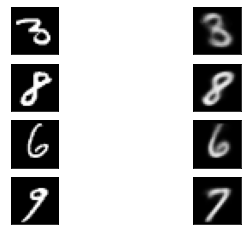

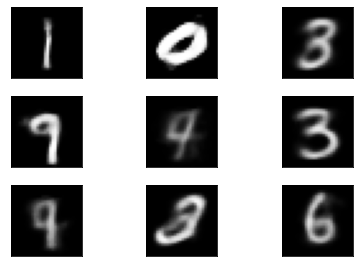

In [9]:
vae2 = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae2.load_state_dict(torch.load('vae2.pt'))
vae2.to(device)
vae2.eval()

_, x= next(enumerate(train_loader))
samples = x[0].to(device)[30:]
samples_rec,   _, _ = vae2(samples)
samples_rec = samples_rec.detach().cpu().view(-1,28,28)
print("Original             Reconstructed")
for i in range(0, 4):
  plt.subplot(4,2,2*i+1)
  imshow(samples[i,0])
    
  plt.subplot(4, 2, 2*i+2)
  imshow(samples_rec[i])
plt.show()

for i in range(1, 10):
    plt.subplot(3,3,i)
    sample = vae2.sampling(n=1).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])
plt.show()

With increase latent space dimension ($dim(z) = 16$) the training loss is improved only slightly. Visibly, the reconstruction has slightly improved. The reconstruction of the 3 is more accurate. 

### Training CVAE
We optimize in the following the CVAE (simpy run the code).

In [27]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]
latent_dim = 2
cvae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim, conditional=True )

cvae = cvae.to(device)
optimizer = optim.Adam(cvae.parameters())


def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = cvae(x, y)
        loss = loss_function(recon_batch, x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    
# Training of CVAE
for epoch in range(1, 15):
    train(epoch)
#torch.save(cvae.state_dict(), 'cvae.pt')

cvae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim, conditional=True, num_labels=10)
cvae.load_state_dict(torch.load('cvae.pt'))
cvae.to(device)
cvae.eval()


Train Epoch: 1 [0/60000 (0%)]	Loss: 5818.291016
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1391.321289
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1295.194824
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1209.536743
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1463.035278
====> Epoch: 1 Average loss: 22.5764
Train Epoch: 2 [0/60000 (0%)]	Loss: 1181.491455
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1198.402954
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1171.750977
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1100.774414
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1176.592285
====> Epoch: 2 Average loss: 18.4203
Train Epoch: 3 [0/60000 (0%)]	Loss: 1054.203857
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1110.915283
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1115.261841
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1077.616699
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1137.510376
====> Epoch: 3 Average loss: 17.3696
Train Epoch: 4 [0/60000 (0%)]	Loss: 1002.239624
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1077.445801
Train Ep

CVAE(
  (encoder): Encoder(
    (lin1): Linear(in_features=794, out_features=512, bias=True)
    (lin2): Linear(in_features=512, out_features=256, bias=True)
    (means): Linear(in_features=256, out_features=2, bias=True)
    (log_vars): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=12, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=512, bias=True)
    (lin3): Linear(in_features=512, out_features=784, bias=True)
  )
)

### Sanity Check CVAE
Check whether your CVAE is able to reconstruct certain images when conditioned on the label (simply run the code).
* Is there a difference to the standard VAE?

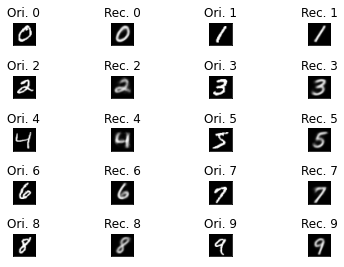

In [11]:
x,l = next(iter(train_loader))
for i in range(0, 10):
    x_one_label = x[l==i][:2]

    samples = x_one_label[:1].to(device)
    labels= i* torch.ones(1).type(torch.long)
    plt.subplot(5,4,2*i+1)
    plt.tight_layout()
    imshow(samples[0,0].cpu())
    plt.title("Ori. {}".format(i))
    
    samples_rec, _, _ = cvae(samples, c = labels)
    samples_rec = samples_rec.detach().cpu().view(-1,28,28)

    plt.subplot(5, 4, 2*i+2)
    plt.tight_layout()
    imshow(samples_rec[0])
    plt.title("Rec. {}".format(i))
plt.show()

Check whether your CVAE is able to generate images from the MNIST dataset distribution by sampling from the latent space and decode these latent codes (simply run the code).
* How do the generated digits compare to those of the VAE?
* Can you imagine why differences could arise?

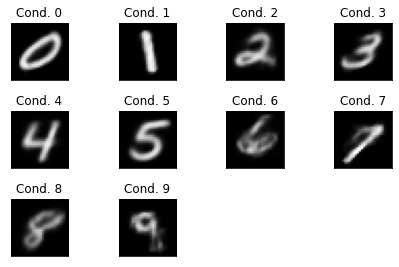

In [12]:
for i in range(0, 10):
    plt.subplot(3,4,i+1)
    label = i* torch.ones(1).type(torch.long)
    sample = cvae.sampling(n=1, c=label).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])
    plt.title("Cond. {}".format(i))
plt.show()

The images are clearly more clear (haha) than the ones generated by VAE. This is obviously due to the fact that CVAE is only training on one class at once, and can therefore use the entire latent space for a single class.

## Task 2: Visualisation of Latent Space of VAE


### Visualisation of output of decoder
Make sure you use the model vae trained with $2$ latent dimensions.

* Illustrate the 2 dimensional latent space by showing decoder output for different values in the latent space (see example on exercise sheet).

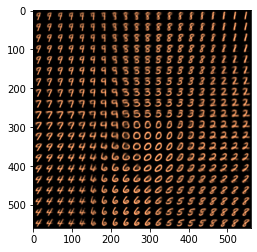

In [13]:
a = 20
img = np.zeros((28*a, 28*a))
scale = np.linspace(-1, 1, a)
for i in range(a):
    for j in range(a):
        out = vae.decoder(torch.tensor([[scale[i], scale[j]]], dtype=torch.float32).to(device)).detach().cpu().numpy().reshape((28,28))
        img[28*i:28*(i+1), 28*j:28*(j+1)] = out

plt.figure()
plt.imshow(img, cmap='copper')
plt.show()

### Visualisation of latent space
In the following, you should visualize the latent space directly.
* Make a scatter plot in latent space, where each plotted point represents the latent code of a single image from the MNIST dataset. Color the points according to the image label.
* What kind of shape should ideally arise?
* What do you see in reality?

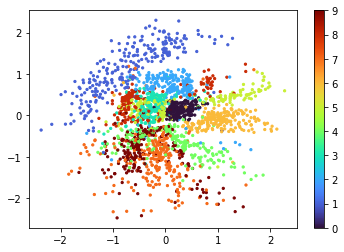

In [14]:
plt.figure()
for batch_idx, data in enumerate(train_loader):
    x, y = data
    x = x.to(device).view(-1, 784)

    mu, log_var = vae.encoder(x)
    mu = mu.detach().cpu().numpy()

    plt.scatter(mu[:,0], mu[:,1], c=y.detach().cpu().numpy(), cmap='turbo', s=5)

    if batch_idx == 16:
        break

plt.colorbar()
plt.show()

Ideally we would want to have some sort of sphere with clearly separated sections corresponding to the respective labels. In actuality we see that some of them are overlapping and the separation might not be as clear as we would ideally like it to be.

### Weaknesses of the VAE
* Find from your plot coordinates in the latent space that migh cause problems to the VAE if you decode this points. Explain your reasoning.
* Illustrate the decoding of one of these points.
* Describe what you see.

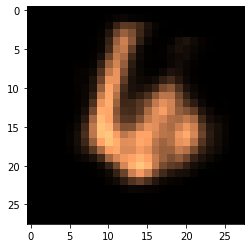

In [15]:
out = vae.decoder(torch.tensor([[0.75, -0.47]], dtype=torch.float32).to(device)).detach().cpu().numpy().reshape((28,28))
plt.figure()
plt.imshow(out, cmap='copper')
plt.show()

This looks like a superposition of a 4 and a 6, which is due to the fact that it is located in the latent space just between these regions. Samples like this might be more difficult to decode than others.

## Task 3: Visualisation of Latent Space of CVAE

Make sure you use the model cvae trained with $2$ latent dimensions.

### Visualisation of Latent Space via Decoder

Repeat task 2 for the CVAE: 
* Illustrate the 2 dimensional latent space by showing the output of the decoder for different values in the latent space (see example on exercise sheet).
* Make two or three of these plots, each conditioned on a fixed label.

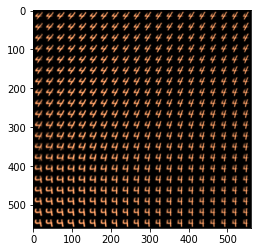

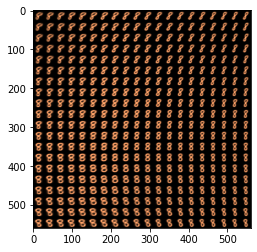

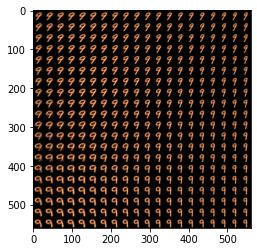

In [16]:
for label in [4, 8, 9]:
    one_hot = np.zeros(10)
    one_hot[label] = 1
    a = 20
    img = np.zeros((28*a, 28*a))
    scale = np.linspace(-1, 1, a)
    for i in range(a):
        for j in range(a):
            out = cvae.decoder(torch.tensor([[scale[i], scale[j], *one_hot]], dtype=torch.float32).to(device)).detach().cpu().numpy().reshape((28,28))
            img[28*i:28*(i+1), 28*j:28*(j+1)] = out

    plt.figure()
    plt.imshow(img, cmap='copper')
    plt.show()
########

### Visualisation of Latent Space via Encoder
* Repeat the scatter plot from Task 2. For each sample, use the correct label as the condition. Color the points according to the label.
* What difference do you see, compared to the standard VAE?
* How to you explain this?
* What does this mean for 'bad samples', as observed in Task 2?


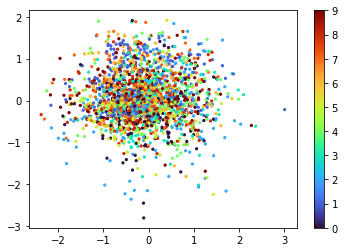

In [17]:
plt.figure()
for batch_idx, data in enumerate(train_loader):
    x, y = data
    one_hot = idx2onehot(y, 10)
    x = x.to(device).view(-1, 784)

    mu, log_var = cvae.encoder(torch.cat((x, one_hot.to(device)), axis=-1).to(device))
    mu = mu.detach().cpu().numpy()

    plt.scatter(mu[:,0], mu[:,1], c=y.detach().cpu().numpy(), cmap='turbo', s=5)

    if batch_idx == 16:
        break

plt.colorbar()
plt.show()

In comparison to VAE, we see no clear differentiation into sections in the latent space here, because the CVAE can use the entire latent space for every class.

## Task 4: Generative Classifier
We define our classifier as maximum a posteriori estimator and expand according to Bayes rule. The label $\hat y$ for a given ..$x$ is predicted according to:

$$ \hat y= \arg \max_y p(y \mid x) = \arg \max_y \frac{p(x \mid y)p(y)}{p(x)} = \arg \max_y \log p(x \mid y) \ ,$$

where the last identity makes use of the fact that $p(y)=1/10$ is constant for all MNIST labels. We can approximate $\log p(x \mid y)$ in the following way: Given an input image, run the CVAE 10 times, each time conditioning one one of the different class labels $y$. Calculate the losses for each case and use them to design a classifier. Note that the network was never trained as classifier, but is still able to perform the task.  

In [24]:
def loss_function_2(recon_x, x, mu, log_var):
    x = x.view(-1, 784)
    log_p_d = torch.norm(x-recon_x, dim=-1, p=2)**2/2
    D_kl = torch.sum(mu**2+torch.exp(log_var)**2-2*log_var-1, axis=-1)/2
    
    return D_kl + log_p_d

def generative_classifier(s):
    sample = torch.tensor(np.array([s,s,s,s,s,s,s,s,s,s]), device=device).view(-1, 784)
    labels = torch.arange(0, 10, 1, device=device)

    recon_batch, mu, log_var = cvae(sample, labels)
    loss = loss_function_2(recon_batch, sample, mu, log_var).detach().cpu().numpy()

    pred = np.argmin(loss)
    return pred

error = []

# run over 10 batches
for _ in range(10):
    x,l = next(iter(train_loader))
    for i in range(128):
        s = x[i].detach().cpu().numpy()
        true = l[i].detach().cpu().numpy()

        pred = generative_classifier(s)
        error.append(pred!=true)

print('classification error: ', np.mean(error))

classification error:  0.05546875


We note that our CVAE as a generative classifier performs admirably.